# Bitcoin Trading
## Enhancing Speed & Accuracy with Dimensionality Reduction

## Problem Definition


## Setup

In [9]:
%pip install numpy pandas matplotlib seaborn scikit-learn graphviz
# 0. Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

# Dimensionality reduction & viz
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.width', 160)
pd.set_option('display.max_columns', 200)

Note: you may need to restart the kernel to use updated packages.


## Load Data & Quick EDA

In [10]:
%pip install kagglehub
# 1. Load data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlfinancebook/bitstamp-bicoin-minutes-data")

print("Path to dataset files:", path)

dataset = pd.read_csv(path+'/'+'BitstampData.csv')

print(dataset.shape)
dataset.tail()

Note: you may need to restart the kernel to use updated packages.
Path to dataset files: /Users/lotfi/.cache/kagglehub/datasets/mlfinancebook/bitstamp-bicoin-minutes-data/versions/1
(2841377, 8)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2841372,1496188560,2190.49,2190.49,2181.37,2181.37,1.700166,3723.784755,2190.247337
2841373,1496188620,2190.50,2197.52,2186.17,2195.63,6.561029,14402.811961,2195.206304
2841374,1496188680,2195.62,2197.52,2191.52,2191.83,15.662847,34361.023647,2193.791712
2841375,1496188740,2195.82,2216.00,2195.82,2203.51,27.090309,59913.492565,2211.620837
2841376,1496188800,2201.70,2209.81,2196.98,2208.33,9.961835,21972.308955,2205.648801


In [11]:
# 1.1 Quick NA check and descriptive stats
print("Any NA? ->", dataset.isnull().values.any())
display(dataset.describe().T)

Any NA? -> True


,count,mean,std,min,25%,50%,75%,max
Timestamp,2841377.0,1.410731e+09,4.938008e+07,1.325318e+09,1.367939e+09,1.410559e+09,1.453568e+09,1.496189e+09
Open,1650904.0,4.958926e+02,3.642453e+02,3.800000e+00,2.399300e+02,4.199800e+02,6.410000e+02,2.754740e+03
High,1650904.0,4.962309e+02,3.645454e+02,3.800000e+00,2.400000e+02,4.200000e+02,6.417200e+02,2.760100e+03
Low,1650904.0,4.955310e+02,3.639298e+02,1.500000e+00,2.398300e+02,4.198500e+02,6.401825e+02,2.752000e+03
Close,1650904.0,4.958933e+02,3.642512e+02,1.500000e+00,2.399300e+02,4.199800e+02,6.410000e+02,2.754820e+03
Volume_(BTC),1650904.0,1.188361e+01,4.093656e+01,0.000000e+00,3.827502e-01,1.823000e+00,8.028465e+00,5.853852e+03
Volume_(Currency),1650904.0,5.316276e+03,1.998227e+04,0.000000e+00,1.239502e+02,6.145704e+02,3.107853e+03,1.865889e+06
Weighted_Price,1650904.0,4.958701e+02,3.642271e+02,3.800000e+00,2.399200e+02,4.199668e+02,6.409529e+02,2.754499e+03


## Cleaning & Label (Buy/Sell)

In [12]:
# 2. Clean & drop timestamp
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()
if 'Timestamp' in dataset.columns:
    dataset = dataset.drop(columns=['Timestamp'])

# 2.1 Create short/long MAs and the binary signal
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()
dataset['long_mavg']  = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)
dataset[['Close','short_mavg','long_mavg','signal']].tail()

,Close,short_mavg,long_mavg,signal
2841372,2181.37,2179.259,2189.616000,0.0
2841373,2195.63,2181.622,2189.877000,0.0
2841374,2191.83,2183.605,2189.943000,0.0
2841375,2203.51,2187.018,2190.203667,0.0
2841376,2208.33,2190.712,2190.509500,1.0


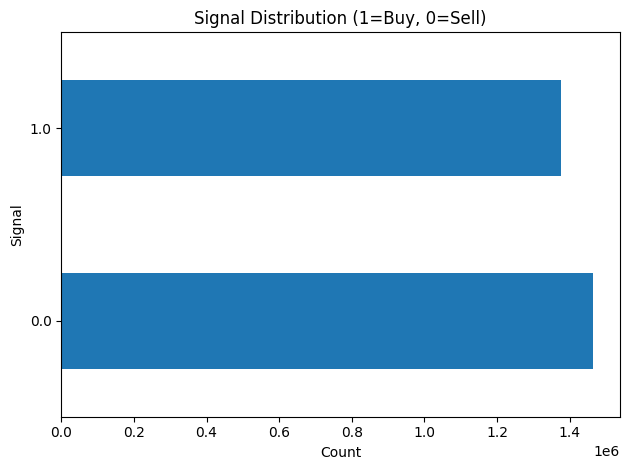

Buy frequency: 48.44%


In [13]:
# 2.2 Class balance visual
fig = plt.figure()
dataset.groupby('signal').size().plot(kind='barh')
plt.title('Signal Distribution (1=Buy, 0=Sell)')
plt.xlabel('Count'); plt.ylabel('Signal'); plt.tight_layout()
plt.show()

buy_share = 100 * dataset['signal'].mean()
print(f"Buy frequency: {buy_share:.2f}%")

## Feature Engineering: Technical Indicators

We construct a dataset that contains the predictors that will be used to make the signal prediction. Using the bitcoin intraday price data, including daily open, high, low, close, and volume, we compute the following technical indicators:
- Moving Average
- Stochastic Oscillator %K and %D
- Relative Strength Index (RSI)
- Rate Of Change (ROC)
- Momentum (MOM)

In [14]:
# EMA
def EMA(df, n):
    return pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name=f'EMA_{n}')

# ROC
def ROC(series, n):
    M = series.diff(n - 1)
    N = series.shift(n - 1)
    return pd.Series(((M / N) * 100), name=f'ROC_{n}')

# Momentum
def MOM(series, n):
    return pd.Series(series.diff(n), name=f'Momentum_{n}')

# RSI
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta.clip(lower=0)
    d = (-delta).clip(lower=0)
    u.iloc[period-1] = u.iloc[:period].mean()
    d.iloc[period-1] = d.iloc[:period].mean()
    u = u.iloc[period-1:].ewm(com=period-1, adjust=False).mean()
    d = d.iloc[period-1:].ewm(com=period-1, adjust=False).mean()
    rs = u / d
    rsi = 100 - (100 / (1 + rs))
    rsi.index = series.index[-len(rsi):]
    return rsi.rename(f'RSI_{period}')

# Stochastic Oscillator %K and %D
def STOK(close, low, high, n):
    return ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100

def STOD(close, low, high, n):
    return STOK(close, low, high, n).rolling(3).mean()

# Simple MA
def MA(df, n):
    return pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name=f'MA_{n}')

In [15]:
# Compute indicators
dataset['EMA10']  = EMA(dataset, 10)
dataset['EMA30']  = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)

dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

dataset['RSI10']  = RSI(dataset['Close'], 10)
dataset['RSI30']  = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

dataset['%K10']   = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10']   = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30']   = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30']   = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200']  = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200']  = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

dataset['MA21']  = MA(dataset, 21)
dataset['MA63']  = MA(dataset, 63)
dataset['MA252'] = MA(dataset, 252)

# Clean up columns we won't use for modeling directly
dataset_model = dataset.drop(columns=['Open','High','Low','Volume_(Currency)','short_mavg','long_mavg'], errors='ignore')
dataset_model = dataset_model.dropna()

dataset_model.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2841372,2181.37,1.700166,2190.247337,0.0,2181.180516,2182.375659,2211.243521,0.431400,-0.648567,8.42,-15.63,50.969957,47.556925,46.613082,56.446991,73.773629,47.882628,59.889303,16.012288,18.929517,2176.613810,2188.948095,2229.429405
2841373,2195.63,6.561029,2195.206304,0.0,2183.807695,2183.230778,2211.088163,1.087937,-0.062358,23.63,0.02,65.877139,53.486633,47.638469,93.687375,71.712138,93.805310,65.119470,26.697138,20.095909,2176.864762,2189.289365,2229.203135
2841374,2191.83,15.662847,2193.791712,0.0,2185.266296,2183.785567,2210.896539,1.034858,-0.234867,19.83,-5.17,60.436451,51.869865,47.394675,80.995324,77.043230,81.350377,74.346105,23.849843,22.186423,2177.428095,2189.546032,2228.961786
2841375,2203.51,27.090309,2211.620837,0.0,2188.583333,2185.058111,2210.823041,1.479237,0.296770,34.13,6.52,69.140553,56.090194,48.213365,74.204874,82.962524,74.505001,83.220229,32.601529,27.716170,2178.595238,2189.967143,2228.775754
2841376,2208.33,9.961835,2205.648801,1.0,2192.173636,2186.559523,2210.798235,1.625863,0.516161,36.94,11.34,71.968296,57.674570,48.545485,82.810399,79.336866,84.343744,80.066374,36.439720,30.963697,2180.420476,2190.417302,2228.596905


## Quick Visuals

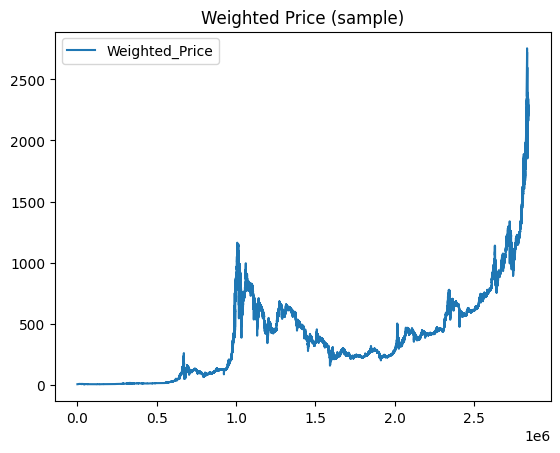

In [16]:
dataset_model[['Weighted_Price']].plot(title='Weighted Price (sample)')
plt.show()

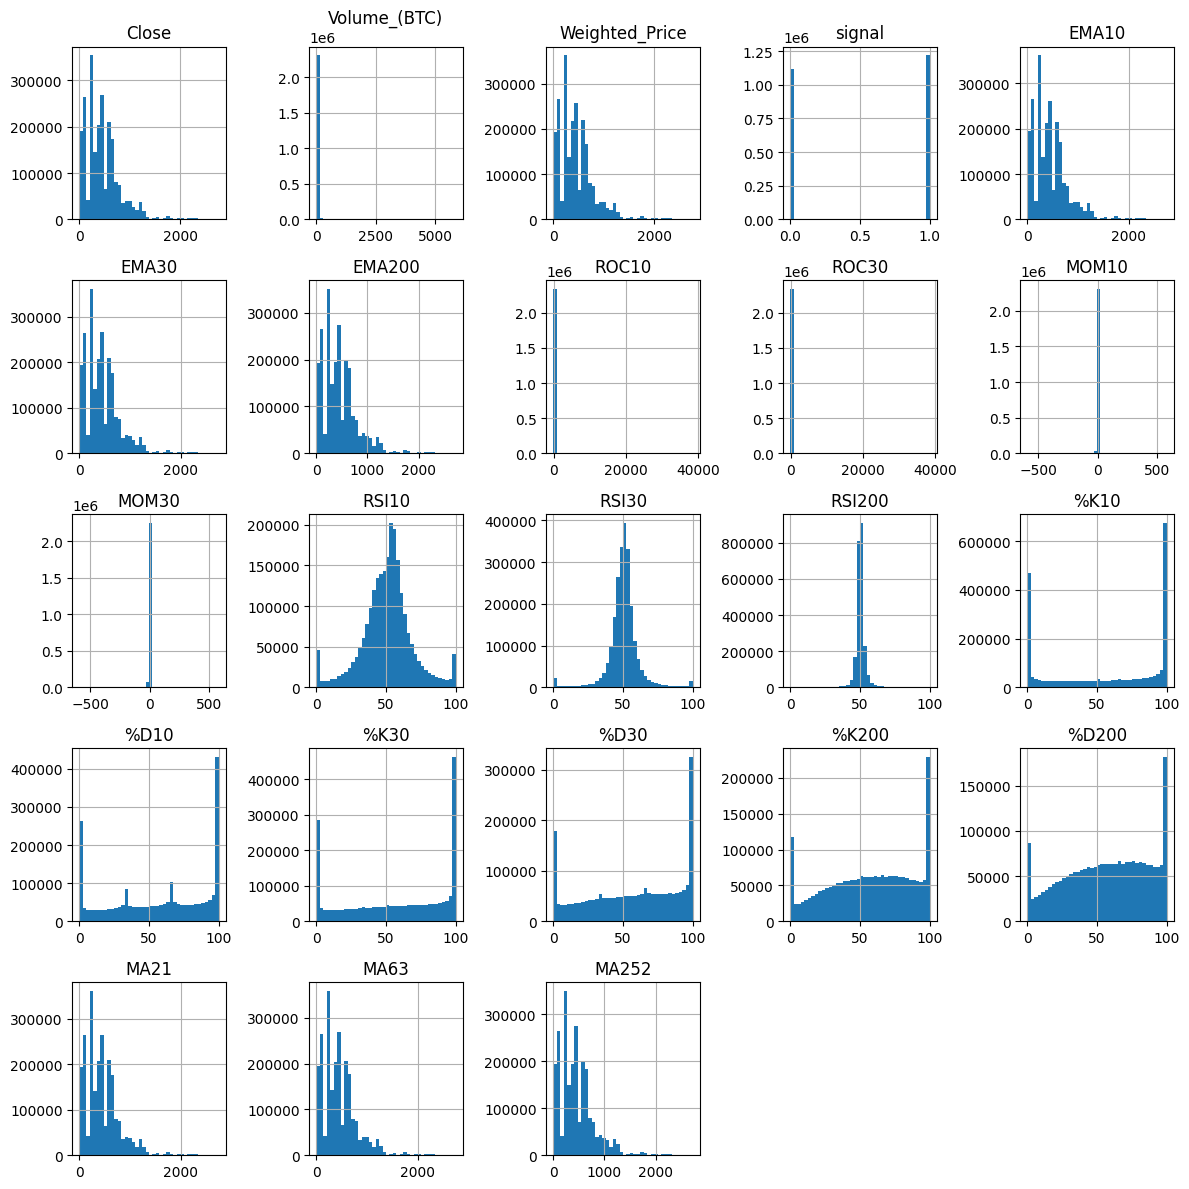

In [17]:
dataset_model.hist(bins=40, figsize=(12, 12))
plt.tight_layout(); plt.show()

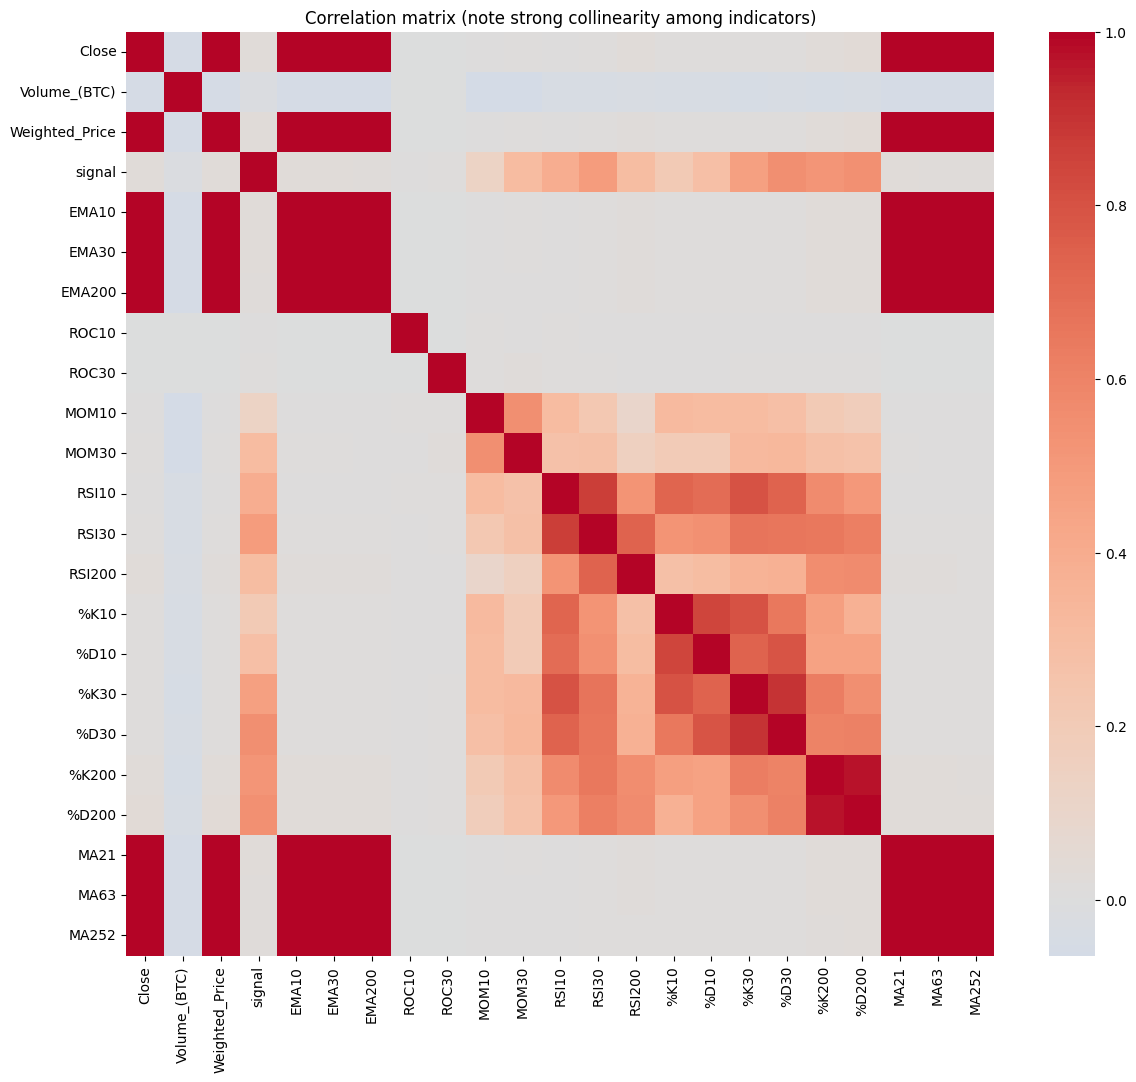

In [18]:
corr = dataset_model.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation matrix (note strong collinearity among indicators)')
plt.show()

In [19]:
# Check class balance again after dropna
(dataset_model['signal'].value_counts(normalize=True) * 100).round(2)

signal
1.0    52.19
0.0    47.81
Name: proportion, dtype: float64

## Train-Test Split

In [20]:
# split out validation dataset for the end
subset_dataset = dataset_model.iloc[-100000:]  # last 100k rows slice
subset_dataset.dropna(how='any', inplace=True)
Y = subset_dataset["signal"]
X = subset_dataset.loc[:, dataset_model.columns != 'signal']

validation_size = 0.2
seed = 1

from sklearn.model_selection import train_test_split
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

## Data Preparation: Standardization

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
rescaledDataset = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

## Dimensionality Reduction with Truncated SVD

In [22]:
ncomps = 5
svd_fit = TruncatedSVD(n_components=ncomps)
Y_pred = svd_fit.fit_transform(rescaledDataset)

Variance preserved by first 5 components == 90.26%


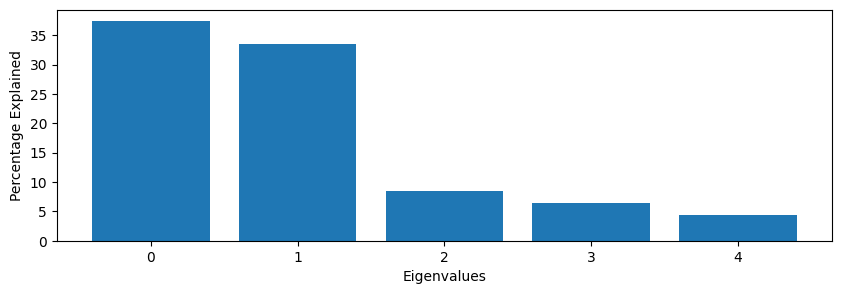

In [23]:
# Plot explained variance
fig, ax = plt.subplots(figsize=(10, 3))
ax.bar(range(ncomps), svd_fit.explained_variance_ratio_ * 100)
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
print('Variance preserved by first 5 components == {:.2%}'.format(
    svd_fit.explained_variance_ratio_.cumsum()[-1]))

## Build a DataFrame for the SVD Features

In [24]:
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(80000, 5)


,c0,c1,c2,c3,c4
2820066,0.326118,-2.353480,-0.547124,1.202562,0.835850
2817800,2.951285,0.778113,-0.388610,-1.055896,-0.626135
2828322,2.527471,-3.141465,0.695528,1.086999,-0.584384
2798804,-0.303100,1.041807,-0.430221,0.003597,-0.003929
2775869,-1.710315,0.857133,1.230156,0.065394,-0.362949


## Pairs Plots (Component Scatter Matrix)

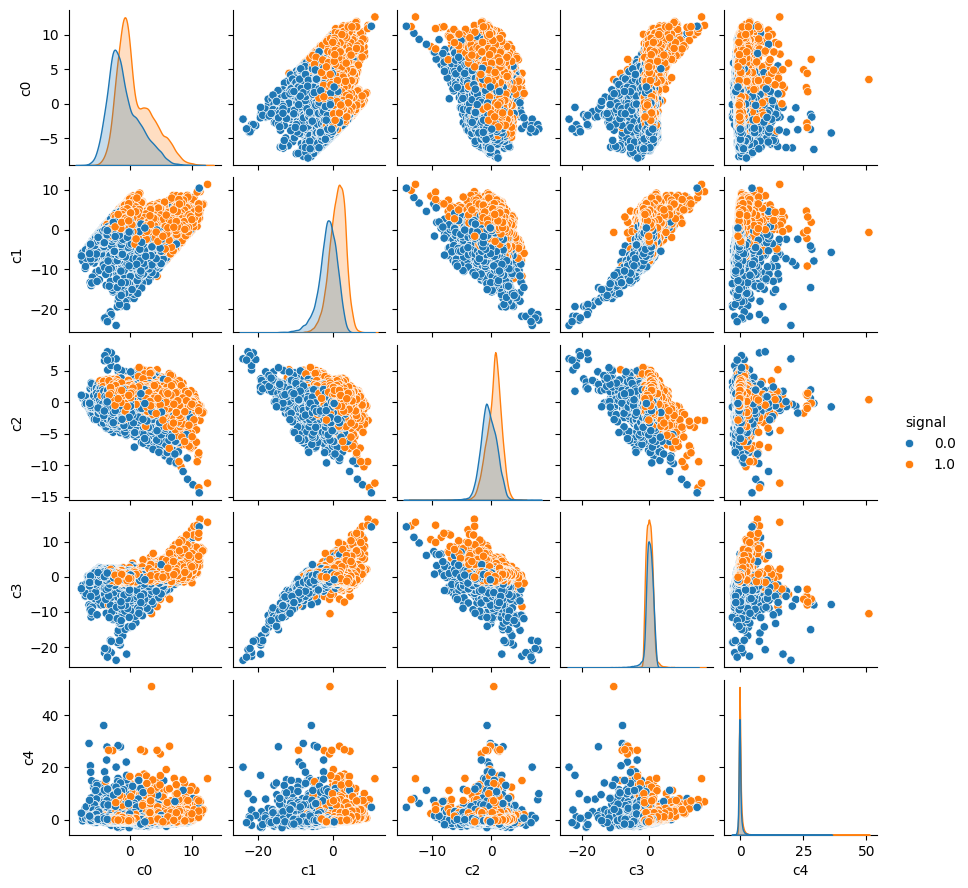

In [25]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:, :plotdims].copy()
dfsvdplot['signal'] = Y_train  # associate labels

ax = sns.pairplot(dfsvdplot.iloc[::ploteorows, :], hue='signal', height=1.8)

## t-SNE Visualization of Compressed Features

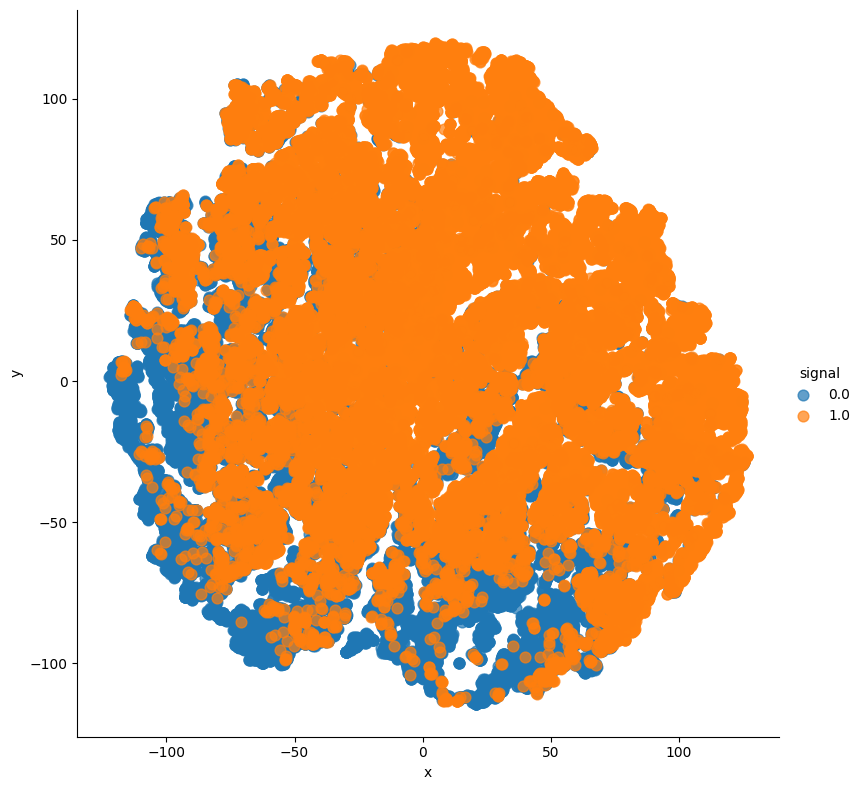

In [26]:
# 2D t-SNE on SVD features
tsne = TSNE(n_components=2, random_state=0)
Z = tsne.fit_transform(dfsvd[svdcols])

dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)
dftsne['signal'] = Y_train

g = sns.lmplot(data=dftsne, x='x', y='y', hue='signal', fit_reg=False, height=8,
               scatter_kws={'alpha':0.7,'s':60})

## Runtime & Accuracy: With vs. Without Dimensionality Reduction

In [27]:
# RF baseline without reduction (timing)
scoring = 'accuracy'

import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

start_time = time.time()
models = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=5)
cv_results_XTrain = cross_val_score(models, X_train, Y_train, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))

Time Without Dimensionality Reduction--- 211.62969326972961 seconds ---
Result without dimensionality Reduction: 0.926288 (0.001886)


In [28]:
# RF with SVD features (timing)
start_time = time.time()
X_SVD = dfsvd[svdcols].iloc[:, :5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=kfold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Time with Dimensionality Reduction--- 68.788094997406 seconds ---
Result with dimensionality Reduction: 0.851550 (0.000839)


## Compare Multiple Algorithms

In [29]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

# spot check the algorithms
models = []

models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))  # Decision Tree
models.append(('NB', GaussianNB()))  # Gaussian NB
# Neural Network
models.append(('NN', MLPClassifier()))  # Multilayer perceptron
# Ensemble Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))  # AdaBoost
models.append(('GBM', GradientBoostingClassifier()))  # Gradient Boosting
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))  # Random Forest

# K-folds cross validation
from sklearn.model_selection import KFold, cross_val_score
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, rescaledDataset, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.912938 (0.003213)
LDA: 0.888562 (0.005198)
KNN: 0.891938 (0.003312)
CART: 0.895263 (0.002598)
NB: 0.789737 (0.004492)
NN: 0.923475 (0.004343)
AB: 0.885175 (0.002697)
GBM: 0.908163 (0.003375)
RF: 0.929200 (0.003358)


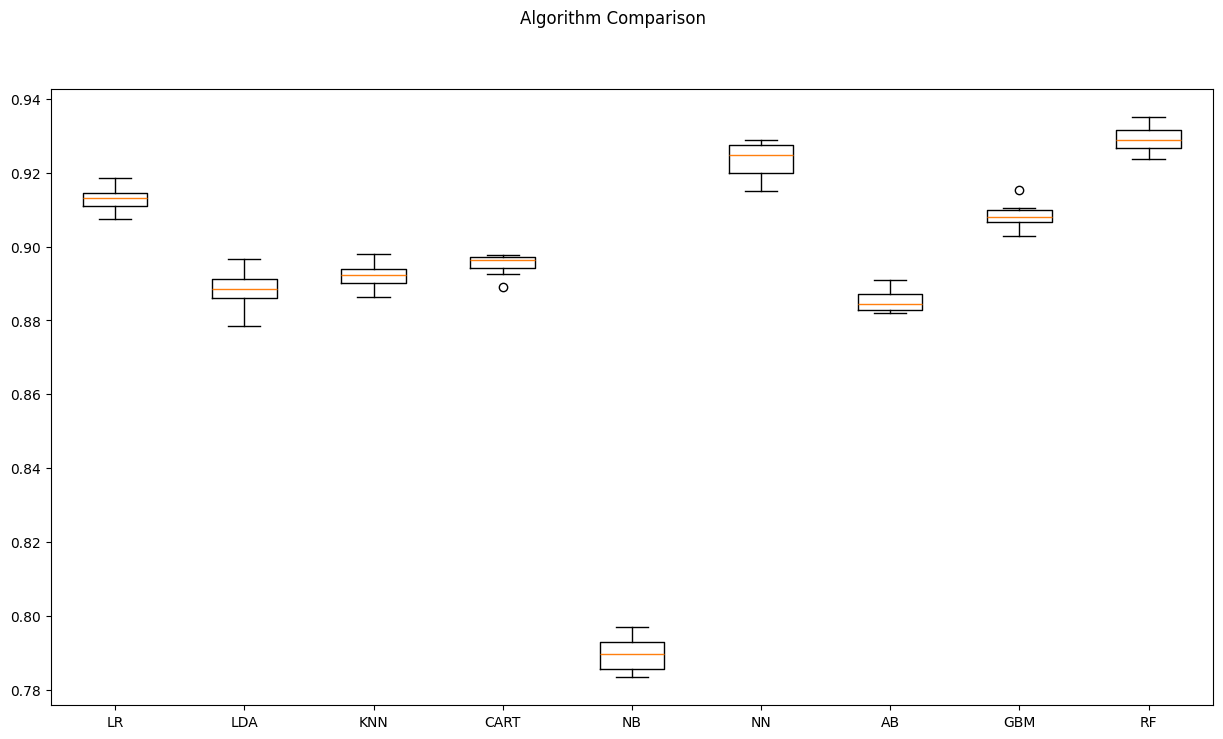

In [30]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

## Model Tuning (Grid Search for Random Forest)

In [31]:
n_estimators = [20, 80]
max_depth = [5, 10]
criterion = ["gini", "entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)

model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledDataset, Y_train)

# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.903150 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#7 0.868275 (0.003501) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.869750 (0.003370) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.900787 (0.003197) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#1 0.903150 (0.003236) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.866975 (0.003351) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.869800 (0.003279) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.900775 (0.003157) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#2 0.902088 (0.002693) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


## Finalize the Model & Evaluate on Validation Set

In [32]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80, max_depth=10, n_jobs=-1)

model.fit(X_train, Y_train)

# estimate accuracy on validation set
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predictions = model.predict(X_validation)

print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9065
[[ 7828   990]
 [  880 10302]]
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      8818
         1.0       0.91      0.92      0.92     11182

    accuracy                           0.91     20000
   macro avg       0.91      0.90      0.91     20000
weighted avg       0.91      0.91      0.91     20000



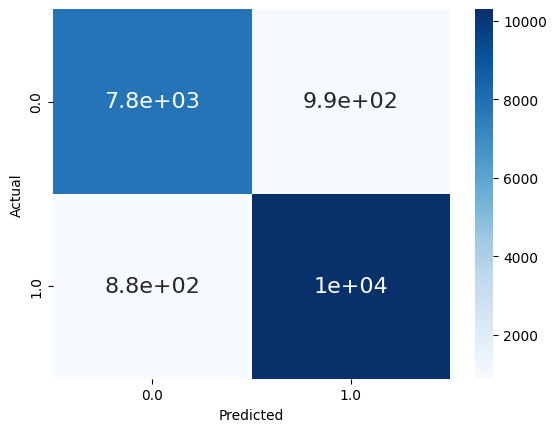

In [33]:
# Confusion matrix heatmap
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions),
                     columns=np.unique(Y_validation), index=np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})
plt.show()

## Feature Importance (Intuition)

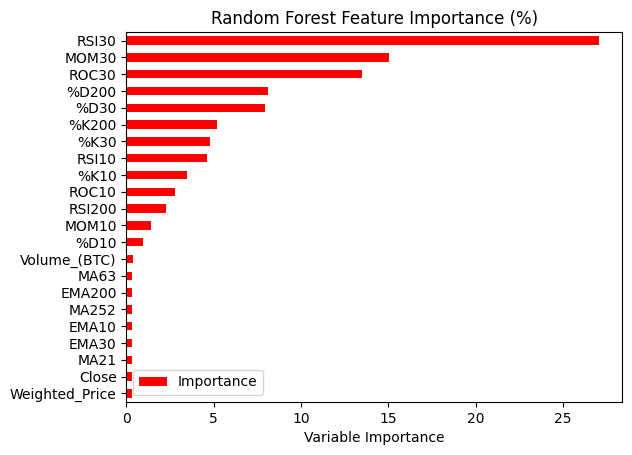

In [34]:
Importance = pd.DataFrame({'Importance': model.feature_importances_ * 100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')
plt.xlabel('Variable Importance')
plt.title('Random Forest Feature Importance (%)')
plt.show()

## Backtesting (Toy)

We turn class predictions into a long-only strategy: if predicted signal=1 at time t-1, be long at time t. Compare Strategy Returns vs. a "Ground Truth" strategy using the actual signal (lagged).

In [35]:
# Create column for Strategy Returns using day-ahead (lagged) position
backtestdata = pd.DataFrame(index=X_validation.index)
backtestdata['signal_pred']   = predictions
backtestdata['signal_actual'] = Y_validation

# Market returns from Close
backtestdata['Market Returns']   = X_validation['Close'].pct_change()

# Actual strategy uses the actual label (lagged)
backtestdata['Actual Returns']   = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)

# Our model strategy uses predicted label (lagged)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)

backtestdata = backtestdata.reset_index()
display(backtestdata.head())

,index,signal_pred,signal_actual,Market Returns,Actual Returns,Strategy Returns
0,2785015,1.0,1.0,NaN,NaN,NaN
1,2828655,1.0,1.0,0.653533,0.653533,0.653533
2,2755426,1.0,1.0,-0.474644,-0.474644,-0.474644
3,2823309,0.0,1.0,0.666725,0.666725,0.666725
4,2836698,1.0,1.0,0.185016,0.185016,0.000000


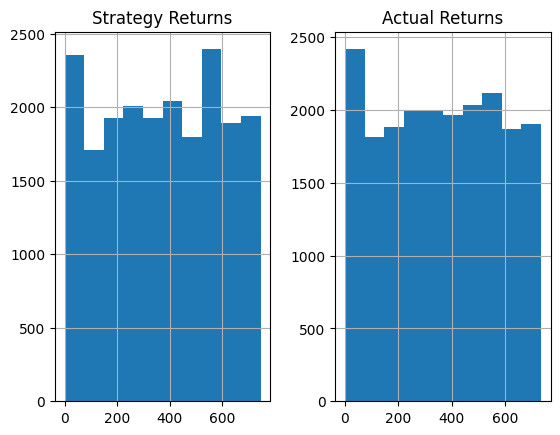

In [36]:
# Distribution and cumulative return plots
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
plt.show()

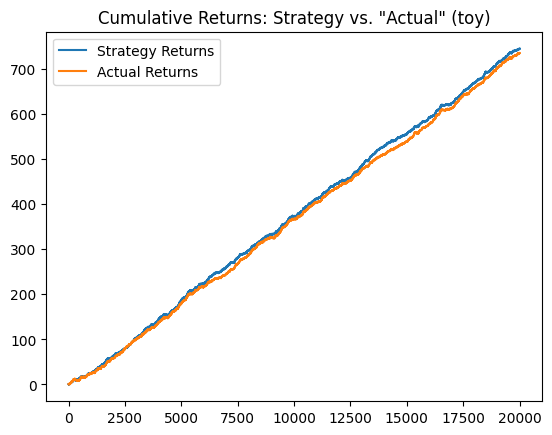

In [37]:
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()
plt.title('Cumulative Returns: Strategy vs. "Actual" (toy)')
plt.show()

In [ ]:
## Sauvegarde du modèle pour le dashboard

import pickle
import os

os.makedirs("bonus_dashboard", exist_ok=True)

# Sauvegarder le modèle Random Forest entraîné
model_path = "bonus_dashboard/bitcoin_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(model, f)

print(f"Modèle sauvegardé: {model_path}")
print(f"Type: {type(model).__name__}")
print(f"Taille: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")

✅ Modèle sauvegardé: bonus_dashboard/bitcoin_model.pkl
📊 Type: RandomForestClassifier
📁 Taille: 8.66 MB
